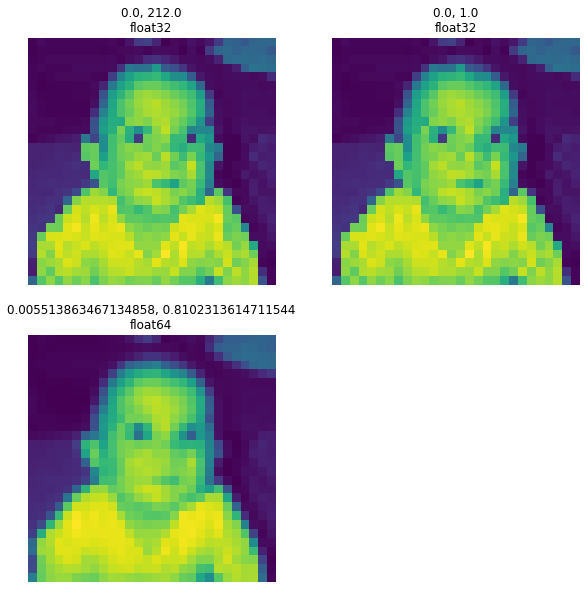

In [54]:
# Read image (two options)
# options to normalize values (0,255 or 0,1)
# force into more than int8
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
import cv2
import numpy as np

from nc_suite import plot_images
size = (28,28)

img_cv2 = np.array(cv2.resize(cv2.imread("data/test/3.jpg",0), size), dtype=np.float32) # float32 to remove overflows in weights matrix

img_sk = imread("data/test/3.jpg",0)
img_sk = rgb2gray(img_sk)
img_sk = resize(img_sk, size)

img_cv2_2 = img_cv2 / np.max(img_cv2) # always do this for everything else to make sense

imgs = [img_cv2,img_cv2_2,img_sk]
imgs_text = ["cv2(0,255)", "sk(0,1)", "cv2/max(0.005,0.8)"]
labels = [f'{np.min(img)}, {np.max(img)}\n{img.dtype}' for img in imgs]

plot_images(imgs, labels)

In [55]:
# try out a few different weightings
# + things like set diagonal to 0 on weights.. or set 0 on laplacian to see which makes differences..
# different laplace calculate methods?
from nc_suite import *

radii = [1] # 784//4, 10

methods = [manual_weight_abs2] # manual_weights_binary2, weight_int
method_names = ["manual_weight_abs2"]
# posts = [zeroes]

weight_labels = []
for imgn in imgs_text:
    for radius in radii:
        for mthn in method_names:
            weight_labels.append(f"{imgn}\n{str(radius)} {mthn}")
        weight_labels.append(f"{imgn}\n{str(radius)} intens_posit_wm")
        
weights = []
for img in imgs:
    for radius in radii:
        temp_out = []
        for method in methods:
            temp_out.append(method(img, radius))
        temp_out.append(intens_posit_wm(img))
        # for post in posts:
        for temp in temp_out:
            weights.append(temp)

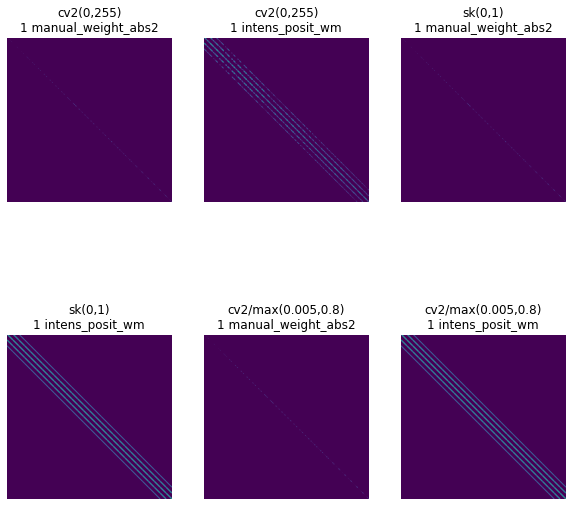

In [56]:
plt.rcParams["figure.figsize"] = (10,10) # specify the size for this cell
plot_images(weights, weight_labels)

In [57]:
def get_laplace(W, num=0, W_zerod=True, L_zerod=False):
    if W_zerod:
        np.fill_diagonal(W,0)
    d = np.sum(W, 1)
    
    if num == 0: # expensive
        sqrt_D_inv = np.diag(np.reciprocal(np.sqrt(d), where=d!=0)) # assumes D is 1 dimensional vector
        D = np.diag(d)
        L = sqrt_D_inv @ (D - W) @ sqrt_D_inv
        
    
    if num == 1: # non symmetrically normalized
        D = np.diag(d)
        L = D-W
   
    # if num == 2: # cheap
    #     shift = 0.5
        
    #     sqrt_D = np.diag(np.sqrt(d)) # assumes D is 1 dimensional vector
    #     D = np.diag(d)
    #     L = sqrt_D @ np.linalg.inv(D * (1-shift) - W) @ sqrt_D # no matmul for the D multiplied by constant factor
        
    if L_zerod:
        np.fill_diagonal(L, 0)
    return L

In [58]:
# cut
# 2-3 different solvers (eig, eigh, something else lobpcg would be nice)
# generalized vs normal? what is not generalized called idk

import scipy.linalg as linalg
import scipy.sparse.linalg as sparse_linalg

laplaces = []
laplace_labels = []
for weight, name_1 in zip(weights, weight_labels):
    for i in range(2):
        laplaces.append(get_laplace(weight, i, True, False))
        laplace_labels.append(f'{name_1}\nlaplace {str(i)} True False')

eig_funcs = [np.linalg.eig, np.linalg.eigh, linalg.eig, linalg.eigh, sparse_linalg.eigs, sparse_linalg.eigsh] # np, sp.linalg, sp.sparse.linalg
            # All may take many params. For now just use default params.
eig_names = ["np.linalg.eig", "np.linalg.eigh", "linalg.eig", "linalg.eigh", "sparse_linalg.eigs", "sparse_linalg.eigsh"]

eig_vecs = []
eig_vecs_labels = []
for func, func_name in zip(eig_funcs, eig_names):
    for L, l_name in zip(laplaces, laplace_labels):
        # caclulate eigenvectors
        w,v = func(L)
        
        # compute second smallest (most will be sorted but best to double check)
        idx = np.argsort(w)[1]  # index of second smallest
        second_smallest_eigenvector = v[:, idx]  # Second smallest eigenvector
        eig_vecs.append(np.real(second_smallest_eigenvector.reshape((28,28)))) 
        eig_vecs_labels.append(f'{l_name}\n{func_name}')

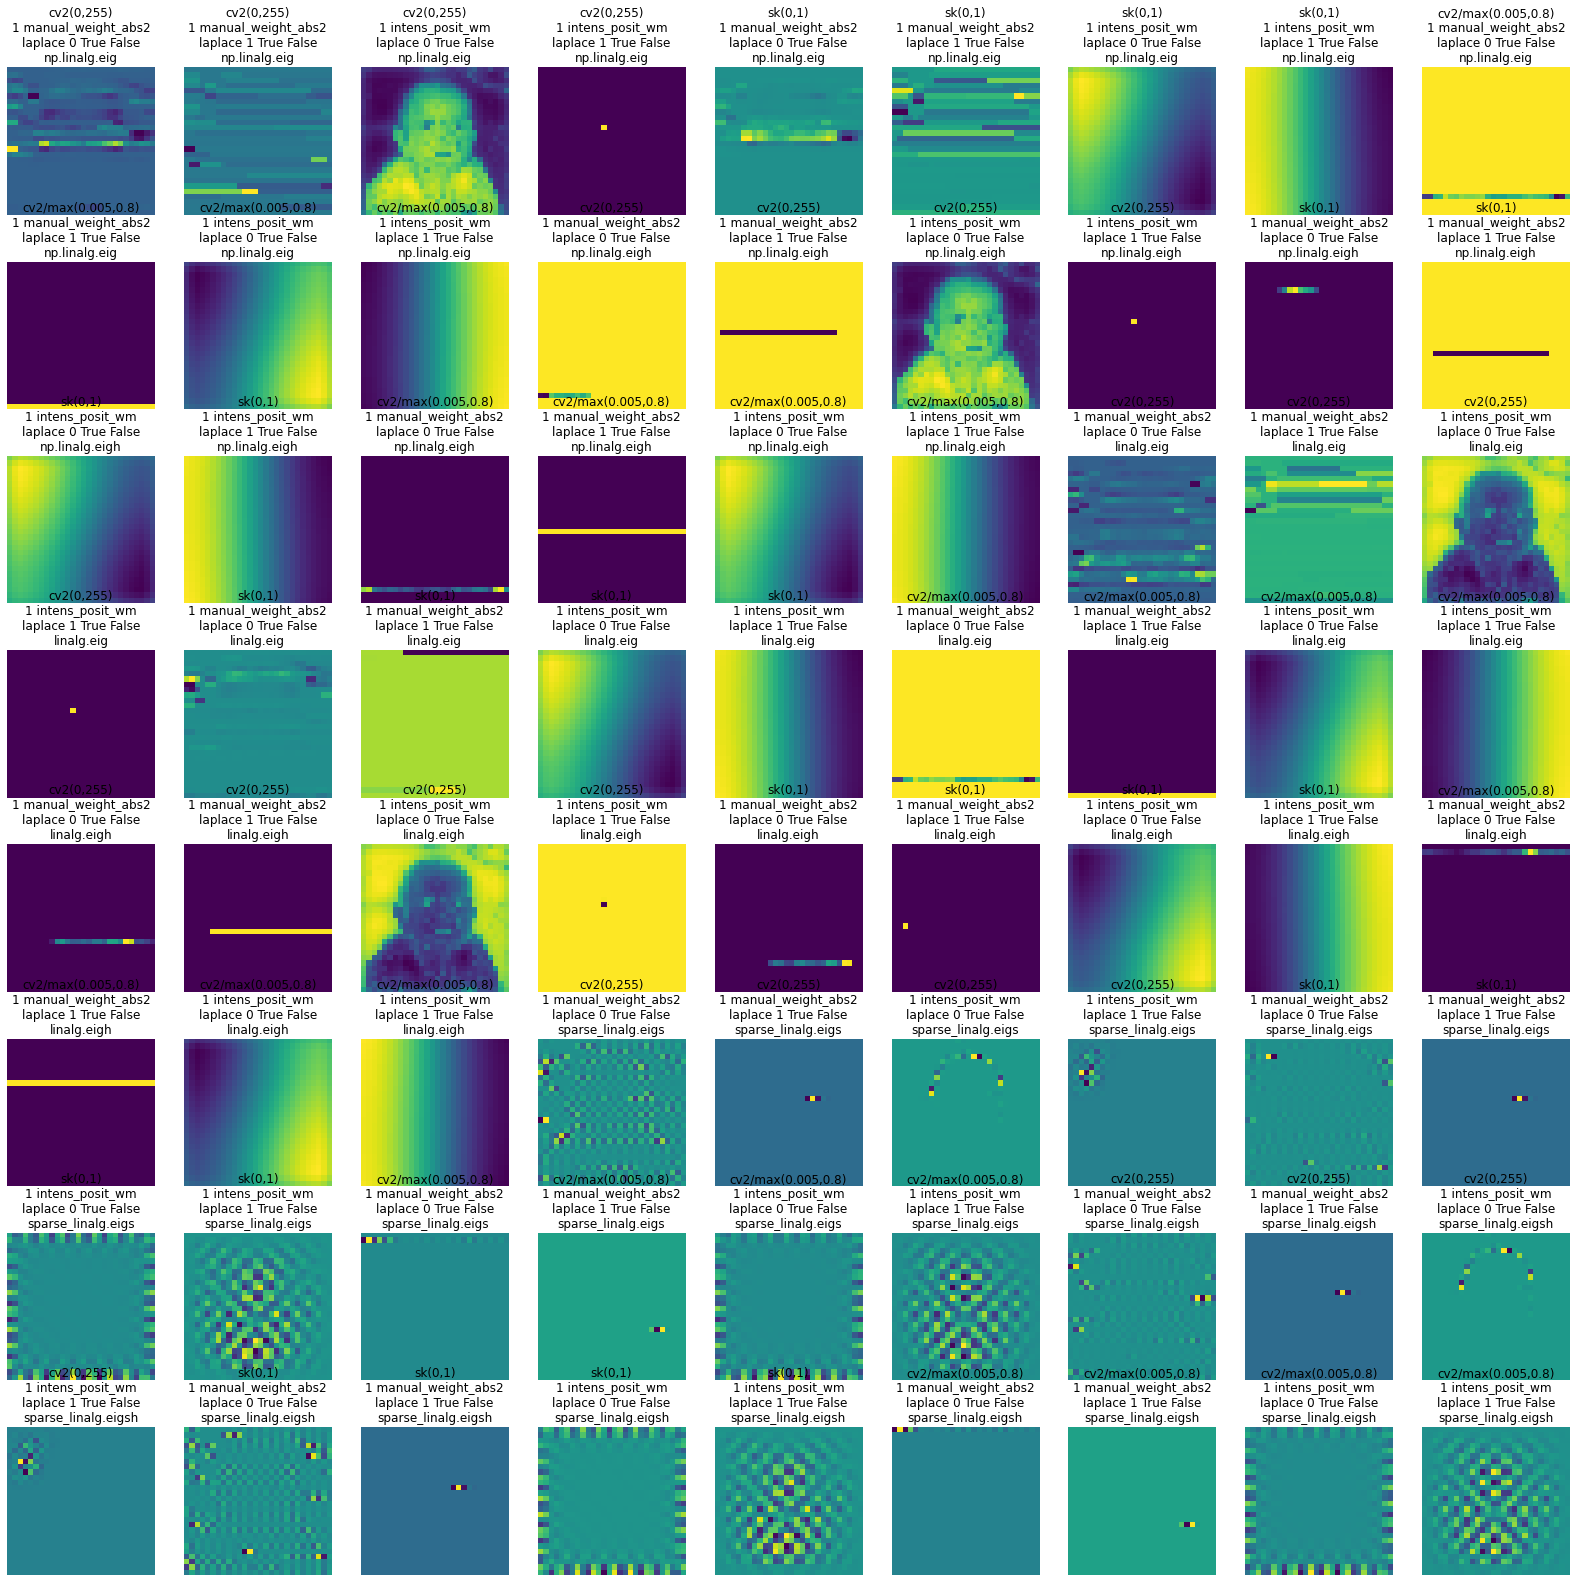

In [59]:
plt.rcParams["figure.figsize"] = (28,28) # specify the size for this cell



plot_images(eig_vecs, eig_vecs_labels)